# Analysis of the results

This notebook investigates the results of all the model runs in the directory `results/runs`.

## Imports and hardcoded variables

In [1]:
import os

import arviz as az
import numpy as np
import pandas as pd
import xarray

from matplotlib import pyplot as plt
from pprint import pprint

RESULTS_DIR = os.path.join("results", "runs")
ARVIZ_STYLE = "arviz-redish"

## Loading InferenceData objects

The results of the analysis are stored as [`InferenceData`](https://arviz-devs.github.io/arviz/api/generated/arviz.InferenceData.html#arviz.InferenceData) objects in [netcdf](https://www.unidata.ucar.edu/software/netcdf/) files. The next cell loads these files.

In [2]:
run_dirs = [
    os.path.join(RESULTS_DIR, d)
    for d in os.listdir(RESULTS_DIR)
    if os.path.isdir(os.path.join(".", RESULTS_DIR, d))
]
priors = {}
posteriors = {}

for run_dir in run_dirs:
    prior_file = os.path.join(run_dir, "prior.nc")
    posterior_file = os.path.join(run_dir, "posterior.nc")
    if os.path.exists(prior_file):
        priors[os.path.basename(run_dir)] = az.from_netcdf(prior_file)
    if os.path.exists(posterior_file):
        posterior = az.from_netcdf(posterior_file)
        posteriors[os.path.basename(run_dir)] = posterior
        
priors["interaction"]

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

Some of the runs may also have results of exact cross-validation, also saved in netcdf files. 

While its convenient to store the cross-validation files separately, for analysis it's nice to have them in the same place as their posteriors, so the next cell loads the cross-validation netcdfs and adds them to the matching posterior `InferenceData`s.

In [3]:
for posterior_name, posterior in posteriors.items():
    llik_cv_file = os.path.join(RESULTS_DIR, posterior_name, "llik_cv.nc")
    if os.path.exists(llik_cv_file):
        llik_cv = xarray.load_dataset(llik_cv_file)
        posterior.add_groups({"log_likelihood_cv": llik_cv})
posteriors["interaction"]

/Users/tedgro/.pyenv/versions/3.9.9/lib/python3.9/site-packages/arviz/data/inference_data.py:1333: UserWarning: The group log_likelihood_cv is not defined in the InferenceData scheme
  warnings.warn(


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> log_likelihood_cv

## Comparing predictions

This cell uses arviz's [`compare`](https://arviz-devs.github.io/arviz/api/generated/arviz.compare.html) function to calculate the approximate leave-one-out expected log predictive density for each `InferenceData` object in the `posteriors` dictionary.

It then calculates the same quantity using exact k-fold cross-validation.

In [4]:
posterior_loo_comparison = az.compare(posteriors)

posterior_kfold_comparison = pd.Series(
    {
        posterior_name:
            float(
                posterior.get("log_likelihood_cv")["llik"]
                .mean(dim=["chain", "draw"])
                .sum()
            )
        for posterior_name, posterior in posteriors.items() 
        if "log_likelihood_cv" in posterior.groups()
    }, name="kfold"
)

posterior_comparison = posterior_loo_comparison.join(posterior_kfold_comparison)

posterior_comparison

/Users/tedgro/.pyenv/versions/3.9.9/lib/python3.9/site-packages/arviz/stats/stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
/Users/tedgro/.pyenv/versions/3.9.9/lib/python3.9/site-packages/arviz/stats/stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
/Users/tedgro/.pyenv/versions/3.9.9/lib/python3.9/site-packages/arviz/stats/stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale,kfold
interaction_fake_data,0,-31.813562,4.297155,0.000000,9.553587e-01,8.254237,0.000000,False,log,-35.941563
no_interaction,1,-85.386182,3.654535,53.572620,4.464130e-02,6.767313,10.921941,False,log,-86.112740
interaction,2,-86.468696,4.291878,54.655134,2.220446e-16,6.741303,10.881154,False,log,-89.019302


## Graphs

The last cell uses arviz to plot each posterior predictive distribution and saves the result to the `plots` directory.

/Users/tedgro/.pyenv/versions/3.9.9/lib/python3.9/site-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)
/Users/tedgro/.pyenv/versions/3.9.9/lib/python3.9/site-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)
/Users/tedgro/.pyenv/versions/3.9.9/lib/python3.9/site-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which

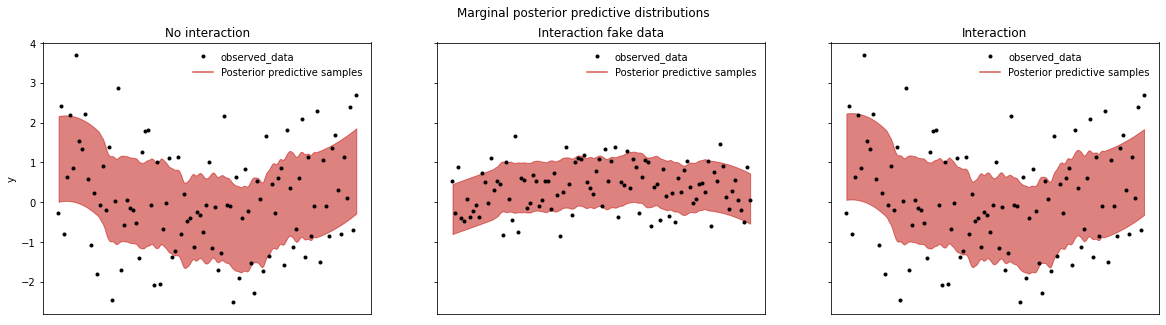

In [5]:
az.style.use(ARVIZ_STYLE)

x = xarray.DataArray(np.linspace(0, 1, 100))
f, axes = plt.subplots(1, 3, figsize=[20, 5], sharey=True)
axes = axes.ravel()
for (posterior_name, posterior), ax in zip(posteriors.items(), axes):
        az.plot_lm(
            y="y",
            x=x,
            idata=posterior,
            y_hat="yrep",
            axes=ax,
            kind_pp="hdi",
            y_kwargs={"markersize": 6, "color":"black"},
            grid=False
        )
        ax.legend(frameon=False)
        ax.set(title=posterior_name.replace("_", " ").capitalize(), ylabel="")
        ax.set_xticks([], [])
axes[0].set_ylabel("y")

f.suptitle("Marginal posterior predictive distributions")
f.savefig(os.path.join("results", "plots", "posterior_predictive_comparison.png"))